In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.early_stopping import EarlyStopping

In [2]:
torch.use_deterministic_algorithms(True)

In [3]:
torch.hub.set_dir('/cs/student/projects1/2021/izaffar/.cache/torch/hub')

In [4]:
DATA_DIR = "../data"
for filename in os.listdir(DATA_DIR):
    print(filename)

images_best_slice
images_slices
info.csv
masks_both
masks_right
mul_mm.png


In [5]:
# Use GPU
# device = "mps" if torch.backends.mps.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [6]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, model_name, mask_type, transform=False, device="cpu"):
        self.data_dir = data_dir
        self.model_name = model_name
        self.transform = transform
        self.device = device

        # image dir
        self.image_dir = os.path.join(data_dir, "images_best_slice")
        self.image_files = sorted(os.listdir(self.image_dir))

        # mask dir
        if mask_type == "both":
            self.mask_dir = os.path.join(data_dir, "masks_both")
        elif mask_type == "right":
            self.mask_dir = os.path.join(data_dir, "masks_right")
        self.mask_files = sorted(os.listdir(self.mask_dir))

        assert len(self.image_files) == len(self.mask_files)

    def slice_transform(self, slice_image):
        if self.model_name == "brain_mri":
            m, s = np.mean(slice_image, axis=(0, 1)), np.std(slice_image, axis=(0, 1))
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.CenterCrop((256, 256)),
                    transforms.Normalize(mean=m, std=s),
                    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
        elif self.model_name == "vgg_16":
            # stack image 3 channels rgb
            slice_image = np.stack((slice_image,) * 3, axis=-1)
            preprocess = transforms.Compose(
                [
                    # transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(),
                    transforms.Resize((224, 224)),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
        input_tensor = preprocess(slice_image)
        return input_tensor

    def mask_transform(self, mask_image):
        if self.model_name == "brain_mri":
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.CenterCrop((256, 256)),
                ]
            )
        elif self.model_name == "vgg_16":
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Resize((224, 224)),
                ]
            )
        input_tensor = preprocess(mask_image)
        return input_tensor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = np.load(image_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)

        # transform
        if self.transform:
            image = self.slice_transform(image).to(self.device)
            mask = self.mask_transform(mask).to(self.device)

        return {"image": image, "mask": mask}


In [7]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=1):
        super().__init__()

        self.encoder = vgg16_bn(weights="DEFAULT").features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        x = self.sigmoid(x)

        return x

In [8]:
def get_pretrained_mri_model():
    pretrained_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)
    # pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
    # pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

    new_in_channels = 1
    modified_encoder1_weight = pretrained_model.encoder1.enc1conv1.weight.data[:, :new_in_channels, :, :]
    pretrained_model.encoder1.enc1conv1 = nn.Conv2d(new_in_channels, 32, kernel_size=3, padding=1)

    # Modify the output channels
    new_out_channels = 1
    modified_conv_weight = pretrained_model.conv.weight.data[:new_out_channels, :, :, :]
    modified_conv_bias = pretrained_model.conv.bias.data[:new_out_channels]
    pretrained_model.conv = nn.Conv2d(32, new_out_channels, kernel_size=1)

    # Assign the modified weights
    pretrained_model.encoder1.enc1conv1.weight.data = modified_encoder1_weight
    pretrained_model.conv.weight.data = modified_conv_weight
    pretrained_model.conv.bias.data = modified_conv_bias
    return pretrained_model

# Load the pre-trained model
def get_model(model_type, device="cpu"):
    if model_type == "vgg_16":
        return UNet(pretrained=True, out_channels=1).to(device)
    elif model_type == "brain_mri":
        return get_pretrained_mri_model().to(device)

In [10]:
class CombinedLoss(nn.Module):
    def __init__(self, adaptive=False, alpha=1.0, threshold_epochs=10, threshold_length_loss=100.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.adaptive = adaptive
        self.threshold_epochs = threshold_epochs
        self.threshold_length_loss = threshold_length_loss
        self.mask_loss_fn = nn.BCELoss()
        self.length_loss_fn = nn.MSELoss()

    def forward(self, pred, pred_lengths, targets, target_lengths, epoch):
        mask_loss = self.mask_loss_fn(pred, targets)
        length_loss = self.length_loss_fn(pred_lengths, target_lengths)
        # length_loss /= 1000.0 # Scale the length loss to be in the same range as the mask loss

        print(mask_loss, length_loss)
        # print(mask_loss.grad_fn, length_loss.grad_fn)

        if not self.adaptive:
            # combined_loss = mask_loss
            combined_loss = mask_loss + self.alpha * length_loss / 1000.0
        else:
            # Combine both losses
            if epoch > self.threshold_epochs and length_loss < self.threshold_length_loss:
                combined_loss = mask_loss + self.alpha * length_loss / 1000.0
            else:
                combined_loss = mask_loss
        return combined_loss

# class CombinedLoss(nn.Module):
#     def __init__(self, initial_alpha=0.5, final_alpha=1.0, num_epochs_to_ramp=10):
#         super(CombinedLoss, self).__init__()
#         self.initial_alpha = initial_alpha
#         self.final_alpha = final_alpha
#         self.num_epochs_to_ramp = num_epochs_to_ramp
#         self.mask_loss_fn = nn.BCELoss()
#         self.length_loss_fn = nn.MSELoss()

#     def forward(self, pred, pred_lengths, targets, target_lengths, epoch):
#         mask_loss = self.mask_loss_fn(pred, targets)
#         length_loss = self.length_loss_fn(pred_lengths, target_lengths)

#         # Calculate the alpha for the current epoch using a linear ramp
#         alpha = min(self.final_alpha, self.initial_alpha + (epoch / self.num_epochs_to_ramp) * (self.final_alpha - self.initial_alpha))

#         # Combine the losses with the specified weights
#         combined_loss = mask_loss + alpha * length_loss
#         return combined_loss

def convert_pixels_to_mm(length_pixels, image_width_pixels, required_image_width_pixels=320, scale_factor=0.56525):
    length_mm = length_pixels * (required_image_width_pixels / image_width_pixels) * scale_factor
    return length_mm

def get_length_line_simple(masks):
    batch_size, _, image_width, image_height = masks.size()
    masks = masks.squeeze(1)
    lengths = []

    for i in range(batch_size):
        mask = masks[i]  # Select the mask for the current sample
        
        # Find indices of non-zero elements (where the mask is 1)
        nonzero_indices = torch.nonzero(mask, as_tuple=False)
        
        if len(nonzero_indices) > 0:
            # Compute the bounding box from the non-zero indices
            min_x = nonzero_indices[:, 1].min().item()
            min_y = nonzero_indices[:, 0].min().item()
            max_x = nonzero_indices[:, 1].max().item()
            max_y = nonzero_indices[:, 0].max().item()

            # Calculate the diagonal length of the bounding box
            width = max_x - min_x
            height = max_y - min_y
            diagonal_length = torch.sqrt(torch.tensor(width**2 + height**2, dtype=torch.float32))
            lengths.append(diagonal_length)
        else:
            lengths.append(torch.tensor(0.0))  # If no non-zero elements found, return length 0

    return torch.stack(lengths)

def get_length_line(masks):
    batch_size, _, image_width, image_height = masks.size()
    masks = masks.squeeze(1)
    lengths = []

    for i in range(batch_size):
        mask = masks[i].cpu().numpy()

        # Apply skeletonization to thin the line
        skeleton = cv2.ximgproc.thinning(mask.astype(np.uint8) * 255)

        # Find contours on the skeleton
        contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # print(contours)

        # Initialize total length
        total_length = torch.tensor(0.0)

        # Iterate through each contour
        for contour in contours:
            # Compute the length of each contour using PyTorch operations
            length_tensor = torch.tensor(
                cv2.arcLength(contour, closed=False), dtype=torch.float32
            )
            total_length += length_tensor

        # total_length = convert_pixels_to_mm(total_length, image_width)
        lengths.append(total_length)
        # print("Total length of the line:", total_length)

    return torch.stack(lengths)


In [11]:
def get_data(model_name, mask_type, val_size, test_size):
    # slice_transform, mask_transform = get_transforms(model_name)
    dataset = CustomDataset(data_dir=DATA_DIR, model_name=model_name, mask_type=mask_type, transform=True, device=DEVICE)

    # Split the data into temporary and test data
    train_val_indices, test_indices = train_test_split(
        list(range(len(dataset))), test_size=(test_size/100), random_state=42
    )

    # Split the temporary data into training and validation
    train_indices, val_indices = train_test_split(
        list(range(len(train_val_indices))), test_size=(val_size/(100-test_size)), random_state=42
    )

    # Create DataLoader for training and testing
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    # print(len(train_loader.dataset))
    # print(len(val_loader.dataset))
    # print(len(test_loader.dataset))

    return train_loader, val_loader, test_loader

In [12]:
# Params
model_name = "brain_mri"
mask_type = "right"
lr = 1e-4
threshold = 0.10
# loss_adaptive = False
# loss_alpha = 0.001
num_epochs = 100
val_size, test_size = 20, 20

batch_size = 4

# ---

# Set fixed random number seed
torch.manual_seed(42)
np.random.seed(42)

# Loss

def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + smooth
    dice_score = (2 * intersection) / union
    return 1 - dice_score

criterion = dice_loss
# criterion = CombinedLoss(adaptive=loss_adaptive, alpha=loss_alpha)

results = {"train_losses": [], "val_losses": [], "diffs": [], "mask_losses": [], "length_losses": []}

# Dataset
dataset = CustomDataset(data_dir=DATA_DIR, model_name=model_name, mask_type=mask_type, transform=True, device=DEVICE)
train_val_indices, test_indices = train_test_split(
    list(range(len(dataset))), test_size=(test_size/100), random_state=42
)
train_indices, val_indices = train_test_split(
    list(range(len(train_val_indices))), test_size=(val_size/(100-test_size)), random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Training
model = get_model(model_name, DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Keep track of loss and epoch for plotting
train_losses = []
val_losses = []
mean_diffs = []
mask_losses = []
length_losses = []
min_val_loss = np.inf

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=50, delta=0.0001, path=f"checkpoint.pt", verbose=True)

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        inputs, targets = batch["image"], batch["mask"]
        outputs = model(inputs)

        pred_masks = (outputs > threshold).float().requires_grad_()
        pred_lengths = get_length_line_simple(pred_masks).requires_grad_()
        targets = (targets > 0).float().requires_grad_()
        target_lengths = get_length_line_simple(targets).requires_grad_()

        # print(inputs.requires_grad)
        # print(targets.requires_grad)
        # print(outputs.requires_grad)
        # print(pred_masks.requires_grad)
        # print(pred_lengths.requires_grad)
        # print(target_lengths.requires_grad)

        # loss = criterion(outputs, pred_lengths, targets, target_lengths, epoch)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    val_loss = 0.0
    mean_diff = 0.0
    mask_loss = 0.0
    length_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, batch in enumerate(val_loader):
            inputs, targets = batch["image"], batch["mask"]
            outputs = model(inputs)

            pred_masks = (outputs > threshold).float()
            pred_lengths = get_length_line_simple(pred_masks)
            pred_lengths_mm = convert_pixels_to_mm(pred_lengths, pred_masks.size(2))
            targets = (targets > 0).float()
            target_lengths = get_length_line_simple(targets)
            target_lengths_mm = convert_pixels_to_mm(target_lengths, targets.size(2))

            # loss = criterion(outputs, pred_lengths, targets, target_lengths, epoch)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            mean_diff += torch.sum(torch.abs(pred_lengths - target_lengths))

            # mask_loss += criterion.mask_loss_fn(pred_masks, targets).item()
            # length_loss += criterion.length_loss_fn(pred_lengths, target_lengths).item()


    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    mean_diff /= len(val_loader.dataset)
    mean_diffs.append(mean_diff)
    # mask_loss /= len(val_loader.dataset)
    # mask_losses.append(mask_loss)
    # length_loss /= len(val_loader.dataset)
    # length_losses.append(length_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Store the results for this fold
results["train_losses"].append(train_losses)
results["val_losses"].append(val_losses)
results["diffs"].append(mean_diffs)
# results["mask_losses"].append(mask_losses)
# results["length_losses"].append(length_losses)
# results["dice"].append(mean_diffs)

# print("Mean diff:", mean_diff.item())

print("\n*** FINISHED TRAINING ***")

Using cache found in /cs/student/projects1/2021/izaffar/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.996331).  Saving model ...


  1%|          | 1/100 [00:01<01:54,  1.16s/it]

Validation loss decreased (0.996331 --> 0.926050).  Saving model ...


  2%|▏         | 2/100 [00:01<01:30,  1.08it/s]

Validation loss decreased (0.926050 --> 0.915846).  Saving model ...


  3%|▎         | 3/100 [00:02<01:23,  1.17it/s]

Validation loss decreased (0.915846 --> 0.863988).  Saving model ...


  5%|▌         | 5/100 [00:03<01:07,  1.40it/s]

Validation loss decreased (0.863988 --> 0.840919).  Saving model ...


  7%|▋         | 7/100 [00:05<01:01,  1.52it/s]

Validation loss decreased (0.840919 --> 0.838758).  Saving model ...


 10%|█         | 10/100 [00:07<00:53,  1.70it/s]

Validation loss decreased (0.838758 --> 0.824482).  Saving model ...


 11%|█         | 11/100 [00:07<01:00,  1.47it/s]

Validation loss decreased (0.824482 --> 0.811083).  Saving model ...


 12%|█▏        | 12/100 [00:08<01:02,  1.41it/s]

Validation loss decreased (0.811083 --> 0.807679).  Saving model ...


 17%|█▋        | 17/100 [00:11<00:44,  1.85it/s]

Validation loss decreased (0.807679 --> 0.778303).  Saving model ...


 31%|███       | 31/100 [00:18<00:33,  2.04it/s]

Validation loss decreased (0.778303 --> 0.772990).  Saving model ...


 81%|████████  | 81/100 [00:43<00:10,  1.85it/s]

Early stopping

*** FINISHED TRAINING ***


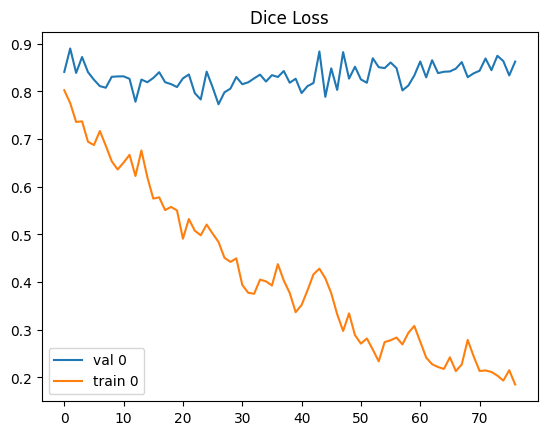

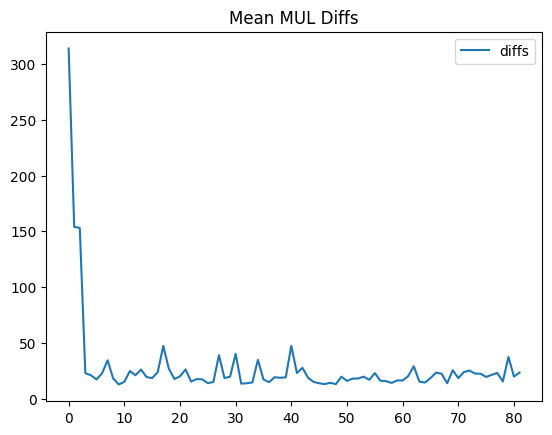

In [13]:
for k in range(1):
    plt.plot(results["val_losses"][k][5:], label=f"val {k}")
for k in range(1):
    plt.plot(results["train_losses"][k][5:], label=f"train {k}")
plt.title(f"Dice Loss")
plt.legend()
plt.show()

# for k in range(1):
#     plt.plot(results["dice"][k][5:], label="Dice")
# plt.title("Dice")
# plt.legend()
# plt.show()

# for k in range(1):
#     plt.plot(results["mask_losses"][k][5:], label="mask")
#     plt.plot(results["length_losses"][k][5:], label="length")
# plt.title("Mask and Length Losses")
# plt.legend()
# plt.show()

for k in range(1):
    plt.plot(results["diffs"][k][0:], label="diffs")
plt.title("Mean MUL Diffs")
plt.legend()
plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [15]:
import pandas as pd

# Convert results dictionary to pandas DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV file
results_csv_filename = f"results_{model_name}_lr{lr:.5f}_a{loss_alpha:.2f}_t{threshold}_e{num_epochs}_m{mask_type}.csv"
results_df.to_csv(results_csv_filename, index=False)

print("Results saved to:", results_csv_filename)

/tmp/ipykernel_54064/4182034505.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ValueError: All arrays must be of the same length

### Evaluation

Mean diff: 7.037381444658552
Std diff: 6.541298275715439
Mean dice: 0.40269382227034795


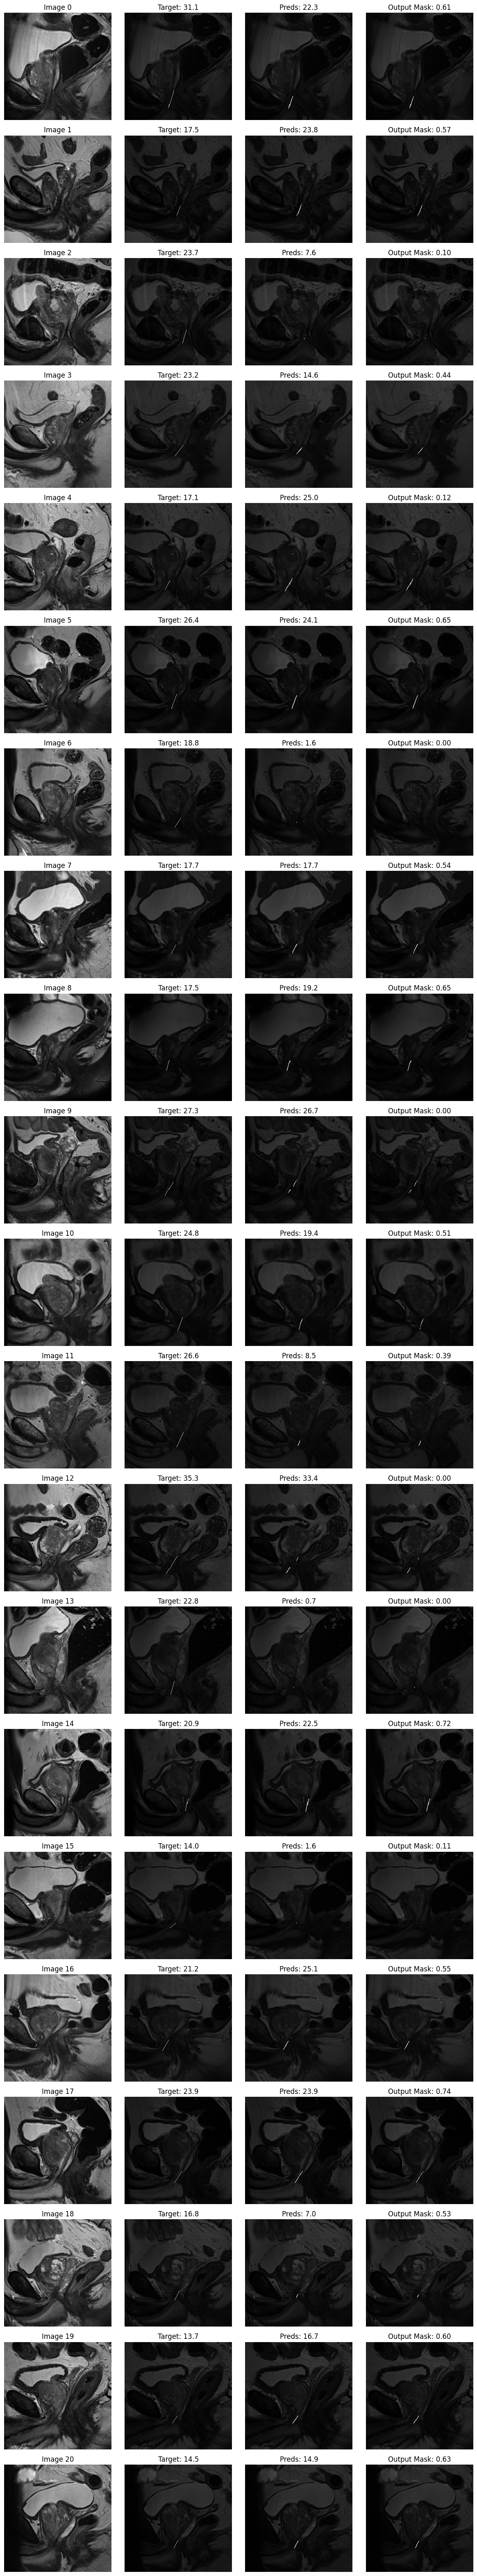

In [18]:
from torchmetrics.functional.classification import dice
import math

def evaluate_model(model, test_loader, threshold=0.05):
    dice_list = []
    diffs_list = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            inputs, targets = batch["image"], batch["mask"]

            # Forward pass
            outputs = model(inputs)

            targets_mask = (targets > 0).float()
            preds_mask = (outputs > threshold).float()

            dice_score = dice(preds_mask, targets_mask.int()).item()
            dice_list.append(dice_score)

            targets_length = get_length_line_simple(targets_mask)
            targets_length_mm = convert_pixels_to_mm(targets_length, targets_mask.size(2))
            # targets_mask_thin = cv2.ximgproc.thinning(targets_mask[0, 0, :, :].detach().cpu().numpy().astype(np.uint8) * 255)

            preds_length = get_length_line_simple(preds_mask)
            preds_length_mm = convert_pixels_to_mm(preds_length, preds_mask.size(2))
            # preds_mask_thin = cv2.ximgproc.thinning(preds_mask[0, 0, :, :].detach().cpu().numpy().astype(np.uint8) * 255)

            diff = torch.sum(torch.abs(preds_length_mm - targets_length_mm)).item()
            diffs_list.append(diff)

    mean_diff = np.mean(diffs_list)
    std_diff = np.std(diffs_list)
    mean_dice = np.mean(dice_list)

    return mean_diff, std_diff, mean_dice

def visualize_results(model, test_loader, threshold=0.05):
    N_IMAGES = len(test_loader.dataset)
    n_batches = math.ceil(N_IMAGES / test_loader.batch_size)
    fig, axs = plt.subplots(N_IMAGES, 4, figsize=(12, 3 * N_IMAGES))

    model.eval()
    image_idx = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            inputs, targets = batch["image"], batch["mask"]

            # Forward pass
            outputs = model(inputs)

            for j in range(inputs.size(0)):
                axs[image_idx, 0].imshow(inputs[j, 0, :, :].detach().cpu().numpy(), cmap="gray")
                axs[image_idx, 0].set_title(f"Image {image_idx}")

                targets_mask = (targets[j] > 0).float()
                preds_mask = (outputs[j] > threshold).float()
                dice_score = dice(preds_mask, targets_mask.int()).item()

                # print(preds_mask.size())
                # print(targets_mask.size())
                targets_length = get_length_line_simple(targets_mask.unsqueeze(0))
                targets_length_mm = convert_pixels_to_mm(targets_length, targets_mask.size(1)).item()

                preds_length = get_length_line_simple(preds_mask.unsqueeze(0))
                preds_length_mm = convert_pixels_to_mm(preds_length, preds_mask.size(1)).item()

                axs[image_idx, 1].imshow(inputs[j, 0, :, :].detach().cpu().numpy(), cmap="gray")
                axs[image_idx, 1].imshow(targets[j, 0, :, :].detach().cpu().numpy(), cmap="gray", interpolation="none", alpha=0.7)
                axs[image_idx, 1].set_title(f"Target: {targets_length_mm:.1f}")

                axs[image_idx, 2].imshow(inputs[j, 0, :, :].detach().cpu().numpy(), cmap="gray")
                axs[image_idx, 2].imshow(preds_mask[0, :, :].detach().cpu().numpy(), cmap="gray", interpolation="none", alpha=0.7)
                axs[image_idx, 2].set_title(f"Preds: {preds_length_mm:.1f}")

                axs[image_idx, 3].imshow(inputs[j, 0, :, :].detach().cpu().numpy(), cmap="gray")
                axs[image_idx, 3].imshow(outputs[j, 0, :, :].detach().cpu().numpy(), cmap="gray", interpolation="none", alpha=0.7)
                axs[image_idx, 3].set_title(f"Output Mask: {dice_score:.2f}")

                # axs[image_idx, j].axis("off")

                image_idx += 1

    for row in axs:
        for ax in row:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

mean_diff, std_diff, mean_dice = evaluate_model(model, test_loader, threshold=0.05)
print("Mean diff:", mean_diff)
print("Std diff:", std_diff)
print("Mean dice:", mean_dice)

visualize_results(model, test_loader, threshold=0.05)

